# Random Forest Regression

#### Importando as bibliotecas e funções 

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from time import time
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

#### Importando o dataset e dividindo entre variáveis de entrada e de saída

In [2]:
df = pd.read_excel('Data_set.xlsx')

df.columns = ['Ethanol_AZ', 'Water_AZ', 'Temperature_AZ', 'Molar_Flow_AZ', 'Reflux_ratio', 'Reboiler_duty',
       'Molar_Flow_ETOH', 'ETOH_Water_Molar_Fraction', 'ETOH_EG_Molar_Fraction', 'ETOH_Ethanol_Molar_Fraction', 'Time']

X_df = df[['Ethanol_AZ', 'Temperature_AZ', 'Molar_Flow_AZ','Reflux_ratio']]
Y_df = df['ETOH_Ethanol_Molar_Fraction']

# Assim temos X e Y como datasets, se quisermos um array com os dados de X e de Y usamos:
X = X_df.values
Y = Y_df.values

#### Separando os dados de entrada e saída em treinamento e teste

In [3]:
default_test_size = 0.2
seed = 42

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=default_test_size, random_state=seed)

#### Definindo os passos do Pipeline

In [4]:
pipe = Pipeline([('scaler',  StandardScaler()), ('regressor', RandomForestRegressor(random_state = seed))])

#### Implementando o GridSearch

In [5]:
tempo_inicial = time()

hyperparameters = {'regressor__n_estimators': [1,3,5,10,100,200],
                   'regressor__max_depth': [2,3,5,10,15,20],
                   'regressor__criterion': ['squared_error','absolute_error', 'friedman_mse'], 
                   'regressor__ccp_alpha': [0.000, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030],
                   'regressor__min_samples_leaf': [1]
                  }
 
grid_search = GridSearchCV(pipe, 
                           param_grid=hyperparameters, 
                           return_train_score=True, 
                           scoring='neg_root_mean_squared_error',    # Parâmetro de escolha da melhor combinação
                           n_jobs=-2,                                # Número de cores de processamento usados simultaneamente.  If n_jobs=-1, all CPUs are used. For n_jobs=-2, all CPUs but one are used.
                           cv = 5,                                   # Determines the cross-validation splitting strategy. 'None' to use the default 5-fold cross validation.
                           verbose = 1)                                   

grid_search.fit(x_train, y_train)
tempo_final = time()
tempo_total = tempo_final-tempo_inicial

print('A operação levou: ', tempo_total)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
A operação levou:  11132.285192012787


In [20]:
grid_df = pd.DataFrame(grid_search.cv_results_)
grid_df.to_excel("RF_GridSearch.xlsx")

#### Feature importances

In [6]:
f_importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

print('\nFeature importances: \n')

for i, j in zip(X_df.columns, f_importances):
    print(f'{i}: {round(j, 4)}')


Feature importances: 

Ethanol_AZ: 0.4551
Temperature_AZ: 0.0017
Molar_Flow_AZ: 0.442
Reflux_ratio: 0.1012


#### Printando os melhores hiperarâmetros segundo o GridSearch

In [7]:
best_params_out = grid_search.best_params_
print('\n Melhores hiperparâmetros:')
print(best_params_out)


 Melhores hiperparâmetros:
{'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'friedman_mse', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}


#### Obtendo o  RMSE de testagem do melhor conjunto de parâmetros segundo o GridSearch

In [8]:
print(f'GridSearch best test RMSE: {round(abs(grid_search.best_score_), 6)}')

GridSearch best test RMSE: 0.001012


#### Rodando os passos do Pipeline agora só com os melhores parâmetros

In [9]:
pipe.set_params(**best_params_out)
                
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)

#### Analisando os diferentes erros de ajuste

In [10]:
rmse_test = math.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print('RMSE    |  MAE    |  MAPE   | R2')
print(f'{round(rmse_test,5)} | {round(mae_test,5)} | {round(mape_test,5)} | {round(r2_test,5)}')

RMSE    |  MAE    |  MAPE   | R2
0.00094 | 0.00044 | 0.00045 | 0.99253


In [11]:
print(f'O MAE representa {round((mae_test/0.994)*100, 2)}% do valor ideal para a fração de etanol no produto')

O MAE representa 0.04% do valor ideal para a fração de etanol no produto


#### Comparando validação e testagem

In [12]:
y_train_pred = pipe.predict(x_train)

math.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {round(math.sqrt(mean_squared_error(y_train, y_train_pred)), 5)} \nTesting RMSE: {round(rmse_test,5)}')

Training RMSE: 0.00036 
Testing RMSE: 0.00094


#### Análises gráficas dos resultados

Primeiro vamos criar um DataFrame com os dados estatísticos

In [13]:
df_comparison = pd.DataFrame()
df_comparison['Predicted_Values'] = y_pred
df_comparison['Real_Values'] = y_test
df_comparison['Percentage_difference'] = 100*(df_comparison['Predicted_Values'] - df_comparison['Real_Values'])/df_comparison['Real_Values']            # Porcentagem do valor real que a diferença entre real e predito representa
df_comparison['Average'] = df_comparison['Real_Values'].mean()                                                                                          # Média dos dados reais 
df_comparison['Q1'] = df_comparison['Real_Values'].quantile(0.25)                                                                                       # Valor abaixo do qual se encontra 25% dos valores do conjunto
df_comparison['Q3'] = df_comparison['Real_Values'].quantile(0.75)                                                                                       # Valor abaixo do qual se encontra 75% dos valores do conjunto           
df_comparison['USL'] = df_comparison['Real_Values'].mean() + (2*df_comparison['Real_Values'].std())
df_comparison['LSL'] = df_comparison['Real_Values'].mean() - (2*df_comparison['Real_Values'].std())

Plotando o primeiro gráfico de todos os valores preditos *versus* valores reais

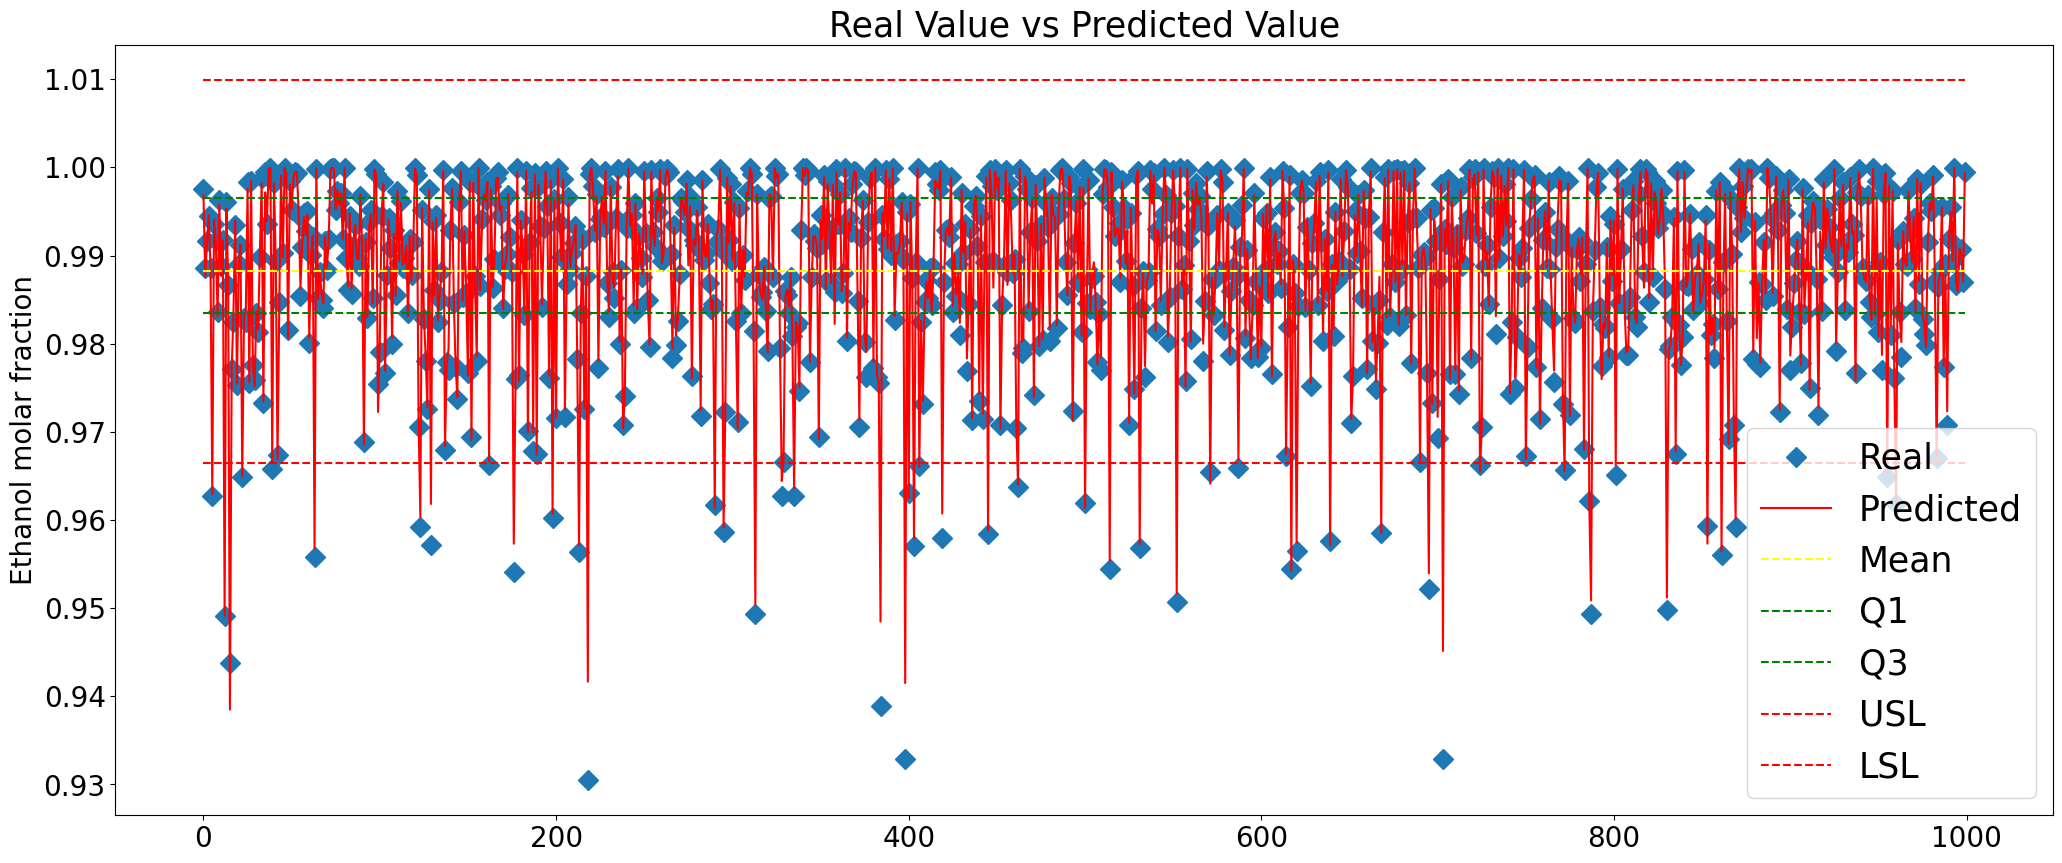

In [14]:
plt.figure(figsize=(25,10))
plt.title('Real Value vs Predicted Value', fontsize=25)
plt.plot(df_comparison.index, df_comparison['Real_Values'], label = 'Real', marker='D', markersize=10, linewidth=0)
plt.plot(df_comparison.index, df_comparison['Predicted_Values'], label = 'Predicted', c='r', linewidth=1.5)
plt.plot(df_comparison.index, df_comparison['Average'], label = 'Mean', linestyle='dashed', c='yellow')
plt.plot(df_comparison.index, df_comparison['Q1'], label = 'Q1', linestyle='dashed',c='g')
plt.plot(df_comparison.index, df_comparison['Q3'], label = 'Q3', linestyle='dashed',c='g')

plt.plot(df_comparison.index, df_comparison['USL'], label = 'USL', linestyle='dashed',c='r')
plt.plot(df_comparison.index, df_comparison['LSL'], label = 'LSL', linestyle='dashed',c='r')

plt.legend(loc='best')
plt.legend(fontsize=25)
plt.ylabel('Ethanol molar fraction', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Como a visualização não ficou muito boa, abaixo é um gráfico dos 100 primeiros valores preditos *versus* valores reais

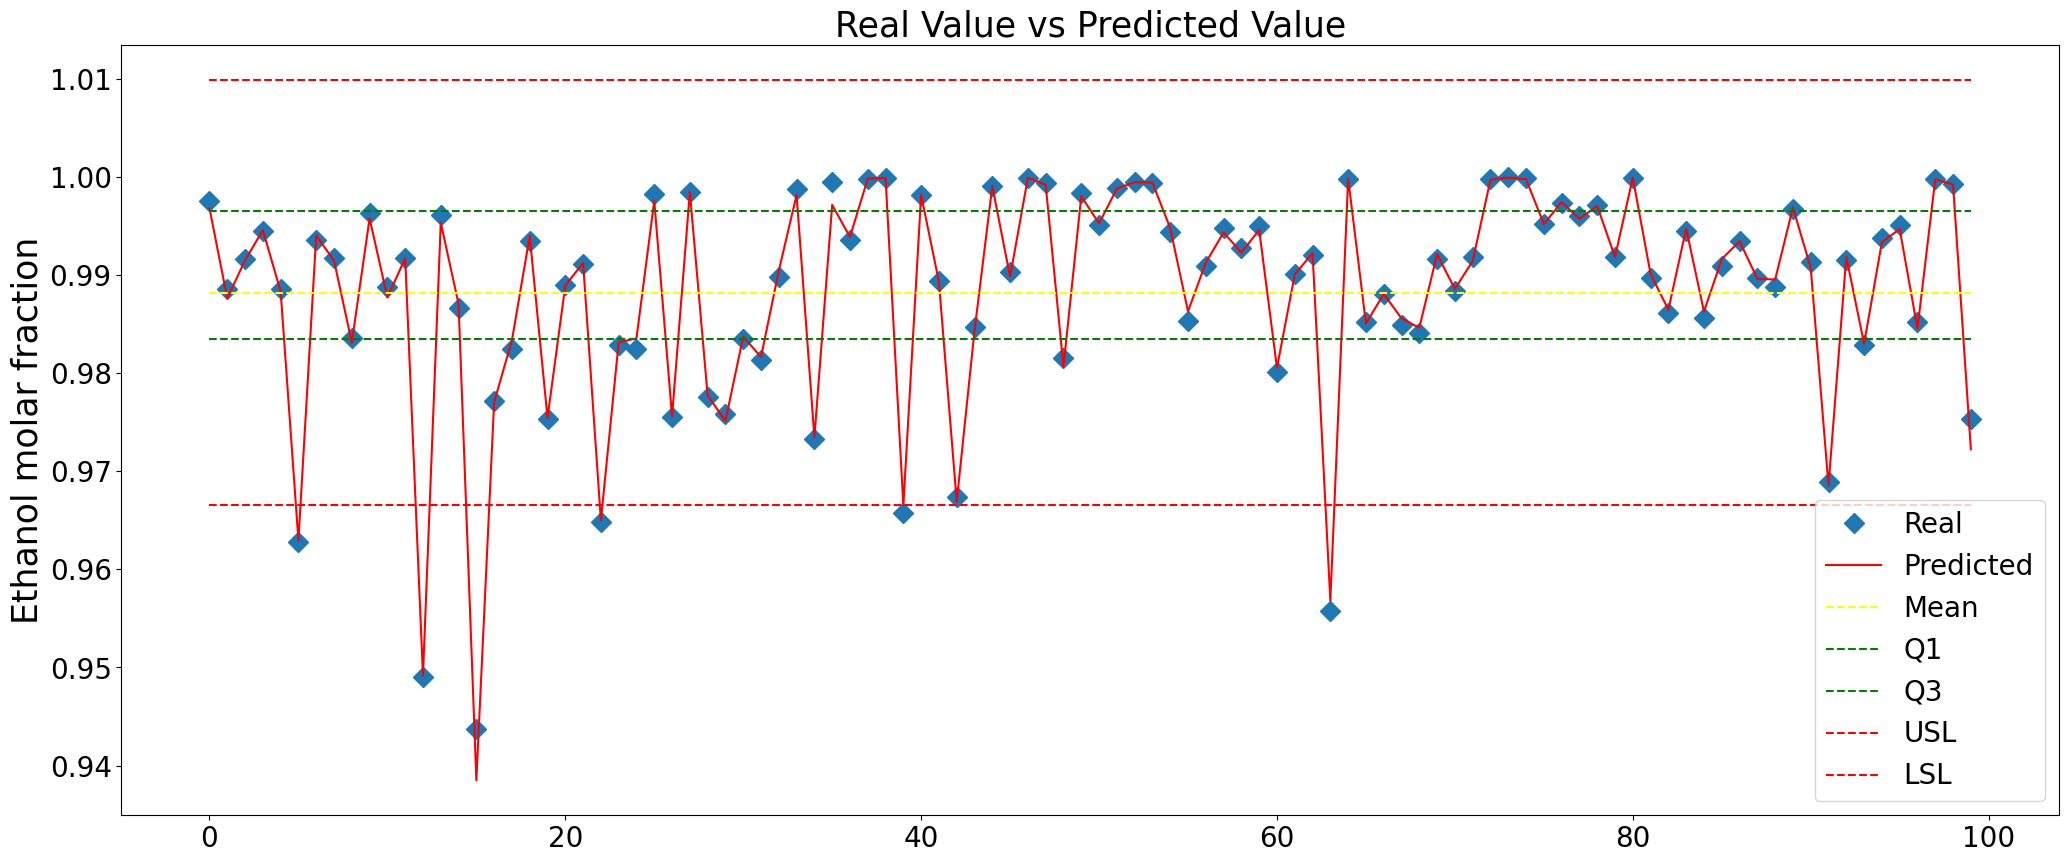

In [15]:
plt.figure(figsize=(25,10))
plt.title('Real Value vs Predicted Value', fontsize=25)
plt.plot(df_comparison.iloc[:100, :].index, df_comparison.iloc[:100, 1], label = 'Real', marker='D', markersize=10, linewidth=0)
plt.plot(df_comparison.iloc[:100, :].index, df_comparison.iloc[:100, 0], label = 'Predicted', color='red', linewidth=1.5)
plt.plot(df_comparison.iloc[:100, :].index, df_comparison.iloc[:100, 3], label = 'Mean', linestyle='dashed', c='yellow')
plt.plot(df_comparison.iloc[:100, :].index, df_comparison.iloc[:100, 4], label = 'Q1', linestyle='dashed',c='g')
plt.plot(df_comparison.iloc[:100, :].index, df_comparison.iloc[:100, 5], label = 'Q3', linestyle='dashed',c='g')
plt.plot(df_comparison.iloc[:100, :].index, df_comparison.iloc[:100, 6], label = 'USL', linestyle='dashed',c='r')
plt.plot(df_comparison.iloc[:100, :].index, df_comparison.iloc[:100, 7], label = 'LSL', linestyle='dashed',c='r')


plt.legend(fontsize=20)
plt.ylabel('Ethanol molar fraction', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Agora plotando só os dados preditos e dados reais

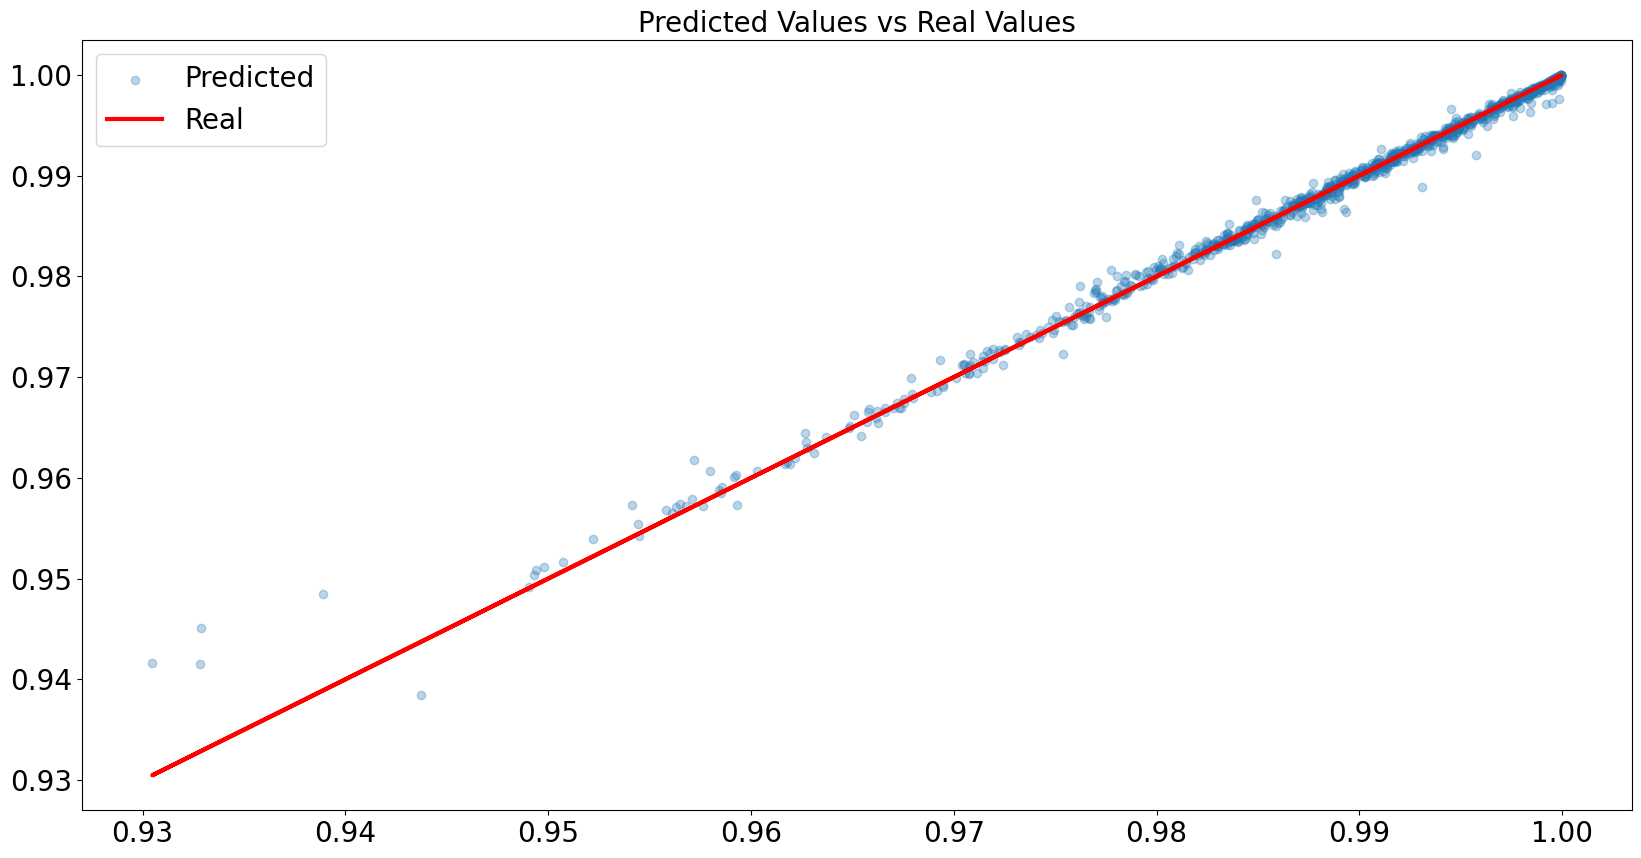

In [16]:
plt.figure(figsize=(20,10))
plt.title('Predicted Values vs Real Values', fontsize=20)
plt.scatter(df_comparison['Real_Values'], df_comparison['Predicted_Values'], label='Predicted', alpha = 0.3)           # Manipular o alpha é interessante para visualizar densidade de pontos
plt.plot(df_comparison['Real_Values'], df_comparison['Real_Values'], color='red', label='Real', linewidth = 3)

plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### Plotando o erro de trainamento e teste em função do conjunto de treinamento

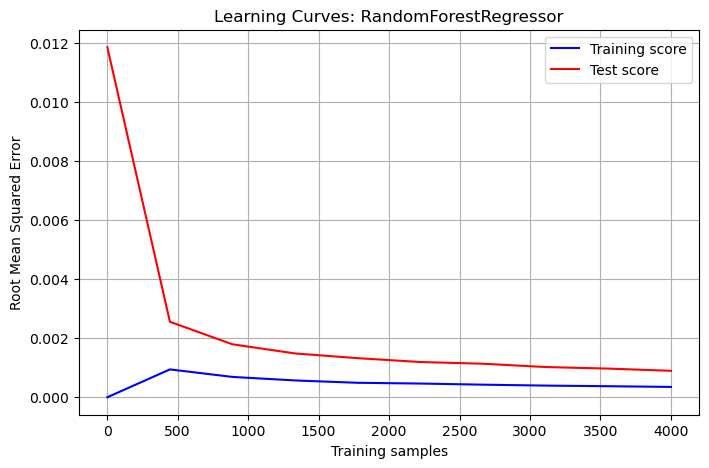

In [8]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, 
                                                        X=X, 
                                                        y=Y, 
                                                        cv=5,
                                                        train_sizes=np.linspace(0.0003, 1, 10), 
                                                        scoring='neg_root_mean_squared_error')

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_mean, label='Test score', color='red')

plt.xlabel('Training samples')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best')
plt.title('Learning Curves: '+ pipe.named_steps['regressor'].__class__.__name__)
plt.grid()
plt.show()

#### Utilizando função

0.0007045710635001812 0.0009362902193333739


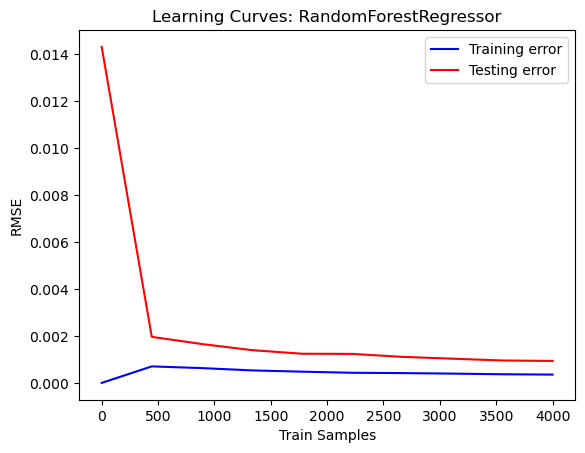

In [9]:
def plot_learning_curve(model, x, y, test_sizes):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    train_score, test_score = [], []
    
    test_sizes = [int(i*len(x_train)) for i in test_sizes]
    
    for i in test_sizes:
        i = int(i)
        model.fit(x_train[:i], y_train[:i])
        y_train_pred = model.predict(x_train[:i])
        y_test_pred = model.predict(x_test)
        train_score.append(np.sqrt(mean_squared_error(y_train[:i], y_train_pred)))
        test_score.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        
    print(max(train_score), min(test_score))
    plt.plot(test_sizes, train_score, color='blue', label='Training error')
    plt.plot(test_sizes, test_score, color='red', label='Testing error')
    plt.legend()
    plt.xlabel('Train Samples')
    plt.ylabel('RMSE')
    plt.title('Learning Curves: '+ pipe.named_steps['regressor'].__class__.__name__)

plot_learning_curve(pipe, X, Y, np.linspace(0.0003, 1, 10))